In [1]:
#Ready
%matplotlib inline

from collections import defaultdict
from IPython import display
from PIL import Image
from torch import nn
from torch.autograd import Variable
from torchvision import models, transforms

import json
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import torch
import image



# Data Acquisition

For this assignment, you must download the dataset provided as a separate link on the course webpage and extract it into `data/`. The dataset contains approximately 20K training images and 100 validation images, with multiple captions/tags for each image. For this assignment, we are only concerned with the tags and ignore the captions.

For question two on the assignment, the dataset also contains a JSON file that maps from the ImageNet labels to the category names. 

Following the data downloading and unzipping, the code below loads in the data into memory accordingly.

In [3]:
#ready
# Define a global transformer to appropriately scale images and subsequently convert them to a Tensor.
img_size = 224
loader = transforms.Compose([
  transforms.Resize(img_size),
  transforms.CenterCrop(img_size),
  transforms.ToTensor(),
]) 
def load_image(filename):
    """
    Simple function to load and preprocess the image.

    1. Open the image.
    2. Scale/crop it and convert it to a float tensor.
    3. Convert it to a variable (all inputs to PyTorch models must be variables).
    4. Add another dimension to the start of the Tensor (b/c VGG expects a batch).
    5. Move the variable onto the GPU.
    """
    image = Image.open(filename).convert('RGB')
    image_tensor = loader(image).float()
    image_var = Variable(image_tensor).unsqueeze(0)
#    return image_var.cuda()
    return image_var

load_image('data/train2014/COCO_train2014_000000000009.jpg')

tensor([[[[0.0039, 0.0078, 0.0039,  ..., 0.0471, 0.0471, 0.0314],
          [0.0039, 0.0039, 0.0039,  ..., 0.0353, 0.0353, 0.0392],
          [0.0039, 0.0039, 0.0039,  ..., 0.0392, 0.0392, 0.0510],
          ...,
          [0.7137, 0.7294, 0.7137,  ..., 0.1686, 0.1843, 0.1686],
          [0.7059, 0.6902, 0.6863,  ..., 0.1765, 0.1804, 0.2039],
          [0.6784, 0.6667, 0.6706,  ..., 0.1922, 0.2157, 0.2275]],

         [[0.1490, 0.1490, 0.1412,  ..., 0.0039, 0.0039, 0.0039],
          [0.1451, 0.1412, 0.1373,  ..., 0.0039, 0.0039, 0.0039],
          [0.1412, 0.1373, 0.1373,  ..., 0.0039, 0.0039, 0.0039],
          ...,
          [0.4392, 0.4667, 0.4549,  ..., 0.2588, 0.2745, 0.2863],
          [0.4353, 0.4235, 0.4196,  ..., 0.2745, 0.2980, 0.3137],
          [0.4118, 0.4000, 0.4000,  ..., 0.3020, 0.3176, 0.3020]],

         [[0.5294, 0.5294, 0.5294,  ..., 0.1451, 0.1412, 0.1333],
          [0.5255, 0.5333, 0.5373,  ..., 0.1725, 0.1451, 0.1412],
          [0.5373, 0.5490, 0.5451,  ..., 0

In [4]:
#ready
# Load ImageNet label to category name mapping.
imagenet_categories = [value for key,value in sorted(json.load(open('data/imagenet_categories.json')).items(), key=lambda t: int(t[0]))]

# Load annotations file for the 20K training images.
mscoco_train = json.load(open('data/annotations/train2014.json'))
train_ids = [entry['id'] for entry in mscoco_train['images']]
train_id_to_file = {entry['id']: 'data/train2014/' + entry['file_name'] for entry in mscoco_train['images']}
category_to_name = {entry['id']: entry['name'] for entry in mscoco_train['categories']}
category_idx_to_name = [entry['name'] for entry in mscoco_train['categories']]
category_to_idx = {entry['id']: i for i,entry in enumerate(mscoco_train['categories'])}

# Load annotations file for the 100 validation images.
mscoco_val = json.load(open('data/annotations/val2014.json'))
val_ids = [entry['id'] for entry in mscoco_val['images']]
val_id_to_file = {entry['id']: 'data/val2014/' + entry['file_name'] for entry in mscoco_val['images']}

# We extract out all of the category labels for the images in the training set. We use a set to ignore 
# duplicate labels.
train_id_to_categories = defaultdict(set)
for entry in mscoco_train['annotations']:
    train_id_to_categories[entry['image_id']].add(entry['category_id'])

# We extract out all of the category labels for the images in the validation set. We use a set to ignore 
# duplicate labels.
val_id_to_categories = defaultdict(set)
for entry in mscoco_val['annotations']:
    val_id_to_categories[entry['image_id']].add(entry['category_id'])

In [5]:
train_id_to_categories[161919]

{1, 49, 79}

In [6]:
id = 243836
train_id_to_file[id]

'data/train2014/COCO_train2014_000000243836.jpg'

Let us take a look at an image and its corresponding category labels. We consider the image with the id 391895 and the corresponding filename, `data/val2014/COCO_val2014_000000391895.jpg`. The image is shown below.

![image](data/val2014/COCO_val2014_000000391895.jpg)

The following code determines the category labels for this image.

In [7]:
for i,category in enumerate(val_id_to_categories[391895]):
    print("%d. %s" % (i, category_to_name[category]))

0. person
1. bicycle
2. motorcycle


# 1. Loading a Pre-trained Convolutional Neural Network (CNN)

We will work with the VGG-16 image classification CNN network first introduced in [Very Deep Convolutional Neural Networks for Large-Scale Image Recognition](https://arxiv.org/pdf/1409.1556.pdf) by K. Simonyan and A. Zisserman.

Fairly straightforwardly, we load the pre-trained VGG model and indicate to PyTorch that we are using the model for inference rather than training.

In [9]:
#Ready
#vgg_model = models.vgg16(pretrained=True).cuda()
vgg_model = models.vgg16(pretrained=True)
vgg_model.eval()

# Let's see what the model looks like.
vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

Linear(in_features=25088, out_features=4096, bias=True)
ReLU(inplace)
Dropout(p=0.5)
Linear(in_features=4096, out_features=4096, bias=True)
ReLU(inplace)
Dropout(p=0.5)
Linear(in_features=4096, out_features=1000, bias=True)


# 2. Making Predictions Using VGG-16

Given the pre-trained network, we must now write the code to make predictions on the 10 validation images via a forward pass through the network. Typically the final layer of VGG-16 is a softmax layer, however the pre-trained PyTorch model that we are using does not have softmax built into the final layer (instead opting to incorporate it into the loss function) and therefore we must **manually** apply softmax to the output of the function.

In [10]:
#Ready
import image
def display_image_val(image_id):
    img_path = val_id_to_file[image_id]
    image = Image.open(img_path)
    plt.figure()
    plt.imshow(image)
    plt.show()


In [11]:
#Ready
def display_image_train(image_id):
    img_path = train_id_to_file[image_id]
    image = Image.open(img_path)
    plt.figure()
    plt.imshow(image)
    plt.show()



In [12]:
#Ready
def display_category_lables(image_id):
    for i,category in enumerate(val_id_to_categories[image_id]):
        print("%d. %s" % (i, category_to_name[category]))

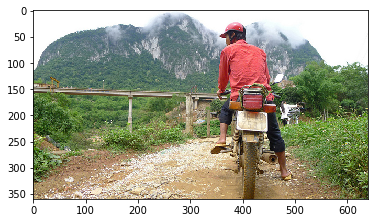

0. person
1. bicycle
2. motorcycle


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


['assault rifle, assault gun', 'stretcher', 'rifle', 'military uniform', 'jeep, landrover']
tensor([0.1598, 0.1121, 0.0801, 0.0570, 0.0456], grad_fn=<TopkBackward>)


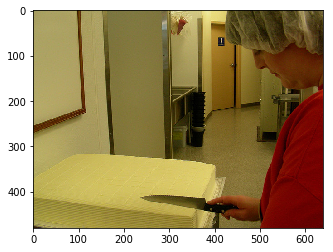

0. sink
1. person
2. cake
3. knife
['mosquito net', 'toilet tissue, toilet paper, bathroom tissue', 'wardrobe, closet, press', 'washbasin, handbasin, washbowl, lavabo, wash-hand basin', 'medicine chest, medicine cabinet']
tensor([0.2567, 0.0837, 0.0812, 0.0465, 0.0376], grad_fn=<TopkBackward>)


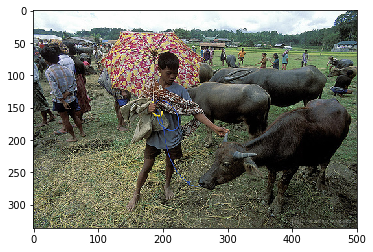

0. person
1. umbrella
2. cow
['Arabian camel, dromedary, Camelus dromedarius', 'sandbar, sand bar', 'Italian greyhound', 'Weimaraner', 'swimming trunks, bathing trunks']
tensor([0.1698, 0.0814, 0.0731, 0.0662, 0.0316], grad_fn=<TopkBackward>)


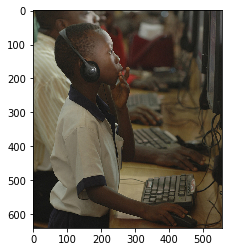

0. tv
1. person
2. mouse
3. keyboard
['plastic bag', 'lab coat, laboratory coat', 'toilet tissue, toilet paper, bathroom tissue', 'bonnet, poke bonnet', 'gasmask, respirator, gas helmet']
tensor([0.1281, 0.0980, 0.0625, 0.0591, 0.0574], grad_fn=<TopkBackward>)


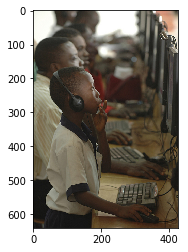

0. tv
1. person
2. mouse
3. keyboard
['plastic bag', 'groom, bridegroom', 'gasmask, respirator, gas helmet', 'toilet tissue, toilet paper, bathroom tissue', 'mosquito net']
tensor([0.0771, 0.0736, 0.0724, 0.0666, 0.0507], grad_fn=<TopkBackward>)


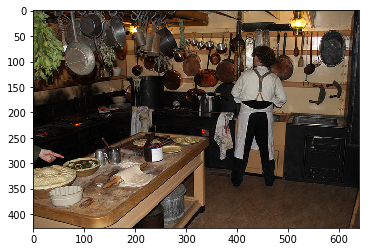

0. person
1. dining table
2. bottle
3. oven
4. cup
5. knife
6. spoon
7. bowl
8. sink
9. broccoli
10. carrot
['dining table, board', 'grand piano, grand', 'mosquito net', 'restaurant, eating house, eating place, eatery', 'desk']
tensor([0.3611, 0.1937, 0.1043, 0.0334, 0.0200], grad_fn=<TopkBackward>)


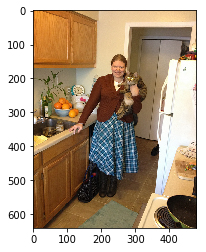

0. potted plant
1. person
2. bottle
3. oven
4. cat
5. refrigerator
6. spoon
7. bowl
8. clock
9. sink
10. orange
11. handbag
['bath towel', 'dishwasher, dish washer, dishwashing machine', 'shower cap', 'bassinet', 'hand blower, blow dryer, blow drier, hair dryer, hair drier']
tensor([0.0899, 0.0896, 0.0555, 0.0478, 0.0467], grad_fn=<TopkBackward>)


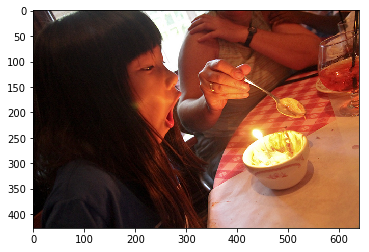

0. person
1. dining table
2. wine glass
3. spoon
4. bowl
['Petri dish', 'bubble', 'groom, bridegroom', 'tub, vat', 'candle, taper, wax light']
tensor([0.2046, 0.0702, 0.0385, 0.0359, 0.0335], grad_fn=<TopkBackward>)


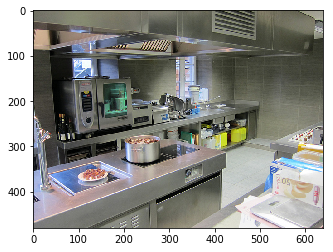

0. sink
1. bowl
2. bottle
3. oven
['photocopier', 'refrigerator, icebox', 'medicine chest, medicine cabinet', 'microwave, microwave oven', 'dishwasher, dish washer, dishwashing machine']
tensor([0.2725, 0.1990, 0.0854, 0.0790, 0.0679], grad_fn=<TopkBackward>)


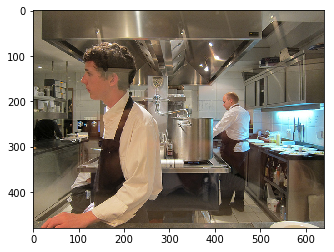

0. person
1. bottle
2. cup
3. knife
4. bowl
5. backpack
['lab coat, laboratory coat', 'mosquito net', 'hoopskirt, crinoline', "pajama, pyjama, pj's, jammies", 'beaker']
tensor([0.4805, 0.2050, 0.0272, 0.0247, 0.0231], grad_fn=<TopkBackward>)


In [13]:

softmax = nn.Softmax()
for image_id in val_ids[:10]:
    # Display the image.
    display_image_val(image_id)
    # Print all of the category labels for this image.
    display_category_lables(image_id)
    # Load/preprocess the image.
    img = load_image(val_id_to_file[image_id])

    # Run the image through the model and softmax.
    label_likelihoods = softmax(vgg_model(img)).squeeze()

    # Get the top 5 labels, and their corresponding likelihoods.
    probs, indices = label_likelihoods.topk(5)


    lables = []
    for i in indices:
        lables.append(imagenet_categories[i])
    print(lables)
    print(probs)
        

# 3. Computing Generic Visual Features using CNN

Since, rather than the output of VGG, we want a fixed sized vector representation of each image, we remove the last linear layer. The implementation of the forward function for VGG is shown below:

```
x = self.features(x)
x = x.view(x.size(0), -1)
x = self.classifier(x)
```
We aim to preserve everything but the final component of the classifier, meaning we must define an alternative equivalent to `self.classifier`.

In [14]:
#Ready
# Remove the final layer of the classifier, and indicate to PyTorch that the model is being used for inference
# rather than training (most importantly, this disables dropout).
    
vgg_model.train(False)
vgg_model.eval()
vgg_model.classifier = nn.Sequential(*list(vgg_model.classifier.children())[:-1])

In [15]:
vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [17]:
#Ready
# First we vectorize all of the features of training images and write the results to a file.

# -- Your code goes here --

training_vectors = []
for image_id in train_ids[:100]:
    img = load_image(train_id_to_file[image_id])

    # Run the image through the model without a softmax.
    features = vgg_model(img).squeeze()
    print(features)
    training_vectors.append(features.data.numpy())
    
np.save(open('outputs/training_vectors', 'wb+'), training_vectors)

tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<SqueezeBackward0>)
tensor([0.0000, 0.0000, 0.0000,  ..., 0.3741, 0.0000, 0.1152],
       grad_fn=<SqueezeBackward0>)
tensor([0.0000, 0.0000, 0.0000,  ..., 0.3843, 0.0000, 0.0000],
       grad_fn=<SqueezeBackward0>)
tensor([0.0000, 0.1357, 0.1310,  ..., 0.4244, 0.0000, 0.0000],
       grad_fn=<SqueezeBackward0>)
tensor([0.0000, 0.0000, 0.0000,  ..., 0.4797, 0.0000, 0.4718],
       grad_fn=<SqueezeBackward0>)
tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<SqueezeBackward0>)
tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0205, 0.0678],
       grad_fn=<SqueezeBackward0>)
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 8.5229e-01,
        6.5663e-04], grad_fn=<SqueezeBackward0>)
tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<SqueezeBackward0>)
tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0833, 0.3308],
       grad_fn=<SqueezeBackward0>)
tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0290],
       grad_fn=<SqueezeBa

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.3014, 0.0000],
       grad_fn=<SqueezeBackward0>)
tensor([0.0000, 0.0000, 0.3979,  ..., 0.0000, 0.0000, 0.0000],
       grad_fn=<SqueezeBackward0>)
tensor([0.0000, 0.0000, 0.1287,  ..., 0.0000, 0.6538, 0.0000],
       grad_fn=<SqueezeBackward0>)
tensor([0.0000, 0.0000, 0.3960,  ..., 0.0000, 0.0000, 0.0000],
       grad_fn=<SqueezeBackward0>)
tensor([0.0000, 0.0000, 1.2738,  ..., 0.0000, 0.8026, 0.4852],
       grad_fn=<SqueezeBackward0>)
tensor([0.0000, 0.0000, 0.7858,  ..., 0.0000, 0.0000, 0.4205],
       grad_fn=<SqueezeBackward0>)
tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<SqueezeBackward0>)
tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0825],
       grad_fn=<SqueezeBackward0>)


In [18]:
#Ready
# Next we vectorize all of the features of validation images and write the results to a file.
    

validation_vectors = []
for image_id in val_ids[:100]:
    img = load_image(val_id_to_file[image_id])

    # Run the image through the model without a softmax.
    features = vgg_model(img).squeeze()
    print(features)
    validation_vectors.append(features.data.numpy())
    
np.save(open('outputs/validation_vectors', 'wb+'), validation_vectors)

tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<SqueezeBackward0>)
tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<SqueezeBackward0>)
tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<SqueezeBackward0>)
tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.9122, 0.0000],
       grad_fn=<SqueezeBackward0>)
tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.9678, 0.0368],
       grad_fn=<SqueezeBackward0>)
tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0487, 0.0000],
       grad_fn=<SqueezeBackward0>)
tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<SqueezeBackward0>)
tensor([0.0000, 0.4965, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
       grad_fn=<SqueezeBackward0>)
tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2722],
       grad_fn=<SqueezeBackward0>)
tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<SqueezeBackward0>)
tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0205, 0.2689],
       grad_fn=<SqueezeBackward0>)
tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<SqueezeBackward0>)
tensor([0.

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.3104, 0.0000],
       grad_fn=<SqueezeBackward0>)
tensor([0.0000, 1.3506, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
       grad_fn=<SqueezeBackward0>)
tensor([0.0000, 0.0000, 0.0000,  ..., 0.1111, 0.0000, 0.3211],
       grad_fn=<SqueezeBackward0>)
tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<SqueezeBackward0>)
tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<SqueezeBackward0>)


# 4. Visual Similarity

We now use the generated vectors, to find the closest training image for each validation image. This can easily be done by finding the training vector that minimizes the Euclidean distance for every validation image. We repeat this exercise for the first 10 images in the validation set.

In [19]:
#Ready
training_vectors = np.load('outputs/training_vectors')

In [20]:
#Ready
validation_vectors = np.load('outputs/validation_vectors')

In [34]:
for i in range(training_vectors.shape[0]):
    print(i)

0
1
2
3
4


4


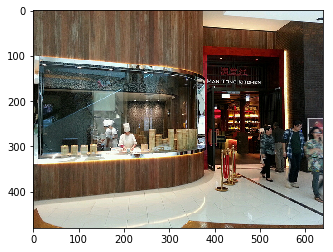

1


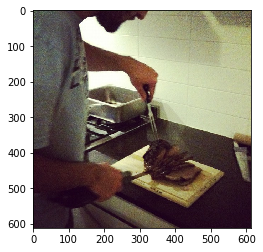

8


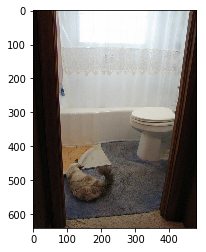

1


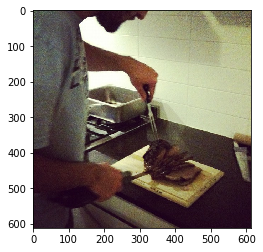

9


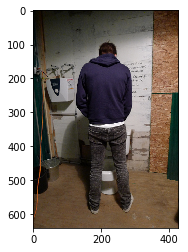

In [20]:
#Ready
from sklearn.metrics.pairwise import euclidean_distances
target_validation = validation_vectors[:10]
distances = euclidean_distances(target_validation, training_vectors)
min_distances = np.argmin(distances, axis=0)

for train_img_id in min_distances:
    print(train_img_id)
    display_image_train(train_ids[train_img_id])
    

# 5. Training a Multi-Label Classification Network

We now build a two layer classification network, which takes 4096-dimensional vectors as input and outputs the probabilities of the 80 categories present in MSCOCO. 

For this purpose, we utilize two layers (both containing sigmoid activation functions) with the hidden dimension set to 512. 

In [21]:
#Ready
D_in, D, D_out = 4096, 512, 80
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(D_in, D)
        self.fc2 = nn.Linear(D, D_out)

    def forward(self, x):
        x = (torch.sigmoid(self.fc1(x)))
        x = (torch.sigmoid(self.fc2(x)))
        return x
    
model = Net()

In [22]:
#Ready
label_size = 80
def preparing_lables():
    labels = torch.tensor(())
    for img_id in train_ids:
        labels_row = torch.zeros(label_size)
        for i,category in enumerate(train_id_to_categories[img_id]):
            if category < label_size:
                labels_row[category] = 1
        labels = torch.cat((labels,labels_row),0)
        
    print("preparing lables is done")
    return labels.view(-1,label_size)

In [51]:
for i,category in enumerate(train_id_to_categories[542854]):
    print(category)

88
18
63


In [74]:
#Ready
# The output data is prepared by representing each output as a binary vector of categories
import torch.optim as optim

tensor_labels = preparing_lables()



def train(model, learning_rate=0.001, batch_size=100, epochs=2):
    """
    Training function which takes as input a model, a learning rate and a batch size.
  
    After completing a full pass over the data, the function exists, and the input model will be trained.
    """
    criterion = nn.MultiLabelSoftMarginLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i in range(int(training_vectors.shape[0]/batch_size)):
            # get the inputs
            
            inputs = torch.tensor(training_vectors[i*batch_size:(i+1)*batch_size,:])
            labels = tensor_labels[i*batch_size:(i+1)*batch_size,:]
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            print(inputs.shape)
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            print(loss)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')

# Finally train the model
train(model)

preparing lables is done
torch.Size([100, 4096])
tensor(0.9646, grad_fn=<MeanBackward1>)
torch.Size([100, 4096])
tensor(0.9646, grad_fn=<MeanBackward1>)
Finished Training


391895


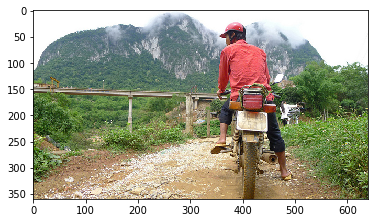

0. person
1. bicycle
2. motorcycle
['clock', 'person', 'hot dog', 'tie', 'train']
tensor([0.0145, 0.0140, 0.0139, 0.0139, 0.0138], grad_fn=<TopkBackward>)
522418


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


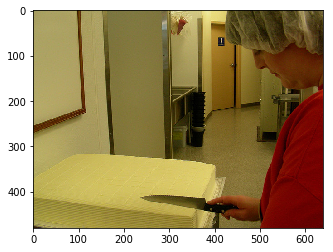

0. sink
1. person
2. cake
3. knife
['clock', 'tie', 'person', 'traffic light', 'train']
tensor([0.0147, 0.0142, 0.0138, 0.0138, 0.0138], grad_fn=<TopkBackward>)
184613


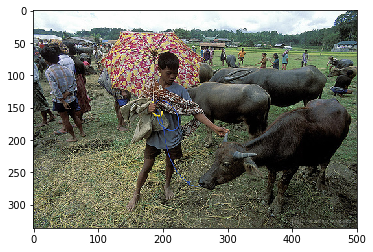

0. person
1. umbrella
2. cow
['clock', 'tie', 'person', 'traffic light', 'train']
tensor([0.0147, 0.0142, 0.0138, 0.0138, 0.0138], grad_fn=<TopkBackward>)
318219


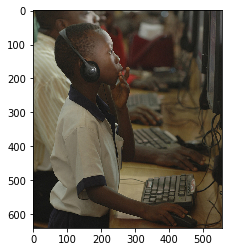

0. tv
1. person
2. mouse
3. keyboard
['clock', 'tie', 'person', 'traffic light', 'train']
tensor([0.0147, 0.0142, 0.0138, 0.0138, 0.0138], grad_fn=<TopkBackward>)
554625


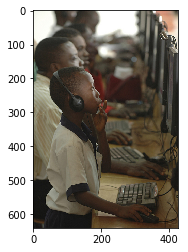

0. tv
1. person
2. mouse
3. keyboard
['clock', 'tie', 'person', 'traffic light', 'train']
tensor([0.0147, 0.0142, 0.0138, 0.0138, 0.0138], grad_fn=<TopkBackward>)
397133


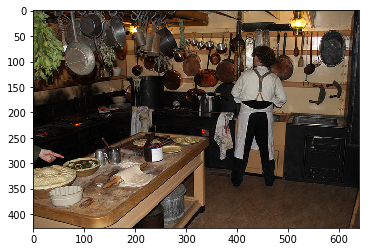

0. person
1. dining table
2. bottle
3. oven
4. cup
5. knife
6. spoon
7. bowl
8. sink
9. broccoli
10. carrot
['clock', 'tie', 'person', 'traffic light', 'train']
tensor([0.0147, 0.0142, 0.0138, 0.0138, 0.0138], grad_fn=<TopkBackward>)
574769


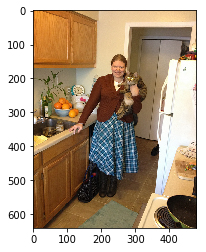

0. potted plant
1. person
2. bottle
3. oven
4. cat
5. refrigerator
6. spoon
7. bowl
8. clock
9. sink
10. orange
11. handbag
['clock', 'tie', 'person', 'traffic light', 'train']
tensor([0.0147, 0.0142, 0.0138, 0.0138, 0.0138], grad_fn=<TopkBackward>)
60623


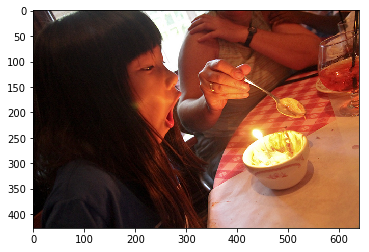

0. person
1. dining table
2. wine glass
3. spoon
4. bowl
['clock', 'tie', 'person', 'traffic light', 'train']
tensor([0.0147, 0.0142, 0.0138, 0.0138, 0.0138], grad_fn=<TopkBackward>)
309022


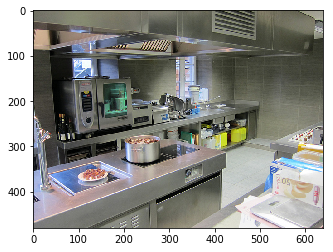

0. sink
1. bowl
2. bottle
3. oven
['clock', 'tie', 'person', 'traffic light', 'train']
tensor([0.0147, 0.0142, 0.0138, 0.0138, 0.0138], grad_fn=<TopkBackward>)
5802


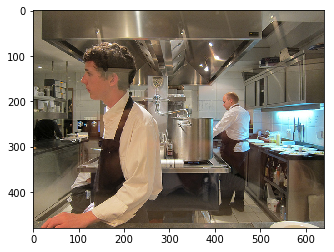

0. person
1. bottle
2. cup
3. knife
4. bowl
5. backpack
['clock', 'tie', 'person', 'traffic light', 'train']
tensor([0.0147, 0.0142, 0.0138, 0.0138, 0.0138], grad_fn=<TopkBackward>)


In [102]:
#Ready
# Now repeat step two using the two layer classifier.

i = 0
for image_id in val_ids[:10]:
    print(image_id)
    # Display the image.
    display_image_val(image_id)
    # Print all of the category labels for this image.
    display_category_lables(image_id)
    # Load/preprocess the image.
    img = load_image(val_id_to_file[image_id])

    
    # Run the image through the model and softmax.
    label_likelihoods = softmax(model(torch.tensor(validation_vectors[i])).squeeze())
    i = i+1

    # Get the top 5 labels, and their corresponding likelihoods.
    probs, indices = label_likelihoods.topk(5)


    lables = []
    for i in indices:
        lables.append(category_idx_to_name[i])
    print(lables)
    print(probs)
        

# 6. End-to-End Model Fine-tuning

Instead of training *only* the final two layers, we now create an end-to-end model and train the entire thing. 

In [97]:
# # First we construct a class for the model

# features = list(vgg_model.classifier.children())# Remove last layer
# for i in model.children():
#     features.extend([i]) # Add our layer with 4 outputs

# vgg_model.classifier = nn.Sequential(*features) # Replace the model classifier
import copy

class E2ENet(nn.Module):
    def __init__(self,old_model):
        super(E2ENet, self).__init__()
        vgg_model=models.vgg16(pretrained=True)
        vgg_model.classifier=nn.Sequential(*list(vgg_model.classifier.children())[:-1])
        self.vgg_model=vgg_model
        self.old_model=copy.deepcopy(old_model)
    
    def forward(self, x):
        x=self.vgg_model(x)
        x=self.two_fc_model(x)
        return x
  

new_model = E2ENet(model)
print(new_model)

E2ENet(
  (vgg_model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace)
      (16): MaxPool2d(kernel_size=2, stride=

In [98]:
print(new_model)

E2ENet(
  (vgg_model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace)
      (16): MaxPool2d(kernel_size=2, stride=

In [96]:
# The output data is prepared by representing each output as a binary vector of categories
# -- Your code goes here --

def train(model, learning_rate=0.001, batch_size=5, epochs=2):
    """
    Training function which takes as input a model, a learning rate and a batch size.
  
    After completing a full pass over the data, the function exists, and the input model will be trained.
    """
    criterion = nn.MultiLabelSoftMarginLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i in range(int(len(train_ids)/batch_size)):
            # get the inputs
            #batch = Variable(torch.empty((0,3,224,224))).cuda()
            batch = Variable(torch.empty((0,3,224,224)))
            for j in range(batch_size):
                print(j)
                id = train_ids[(i*batch_size)+j]
                img = load_image(train_id_to_file[id])
                batch = torch.cat((batch,img),0)
            
            
            labels = tensor_labels[i*batch_size:(i+1)*batch_size,:]
            print(labels)
            # zero the parameter gradients
            
            #print(type(inputs))
            #print(type(training_vectors))
            
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(batch)
            
            loss = criterion(outputs, labels)
            print(loss)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 200 == 199:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 200))
                running_loss = 0.0

    print('Finished Training')
    
    
# Finally train the model
train(new_model)

0
1
2
3
4
tensor(0.6911, grad_fn=<MeanBackward1>)
0
1
2
3
4
tensor(0.6955, grad_fn=<MeanBackward1>)
0
1
2
3
4
tensor(0.6859, grad_fn=<MeanBackward1>)
0
1
2
3
4
tensor(0.6859, grad_fn=<MeanBackward1>)
0
1
2
3
4
tensor(0.6979, grad_fn=<MeanBackward1>)
0
1
2
3
4
tensor(0.6843, grad_fn=<MeanBackward1>)
0
1
2
3
4
tensor(0.6926, grad_fn=<MeanBackward1>)
0
1
2
3
4
tensor(0.6876, grad_fn=<MeanBackward1>)
0
1
2
3
4
tensor(0.6763, grad_fn=<MeanBackward1>)
0
1
2
3
4
tensor(0.6821, grad_fn=<MeanBackward1>)
0
1
2
3
4
tensor(0.6786, grad_fn=<MeanBackward1>)
0
1
2
3
4
tensor(0.6680, grad_fn=<MeanBackward1>)
0
1
2
3
4
tensor(0.6755, grad_fn=<MeanBackward1>)
0
1
2
3
4
tensor(0.6710, grad_fn=<MeanBackward1>)
0
1
2
3
4
tensor(0.6688, grad_fn=<MeanBackward1>)
0
1
2
3
4
tensor(0.6712, grad_fn=<MeanBackward1>)
0
1
2
3
4
tensor(0.6607, grad_fn=<MeanBackward1>)
0
1
2
3
4
tensor(0.6546, grad_fn=<MeanBackward1>)
0
1
2
3
4
tensor(0.6574, grad_fn=<MeanBackward1>)
0
1
2
3
4
tensor(0.6458, grad_fn=<MeanBackward1>)


KeyboardInterrupt: 

In [ ]:
# Now repeat step two using the end-to-end classifier.
# -- Your code goes here --

# 7. Hyper-parameter Tuning

Now we do a grid search over the learning rate and batch size.

In [ ]:
# -- Your code goes here --